Visualise rotation of tumbling satellite under zero external torque but with changing angular velocity.

In [11]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib notebook

#time step interval
timestep=0.05;
#simulation length (end time)
tf=5;

#[Ixv,Iyy,Izz]
Moment_of_Inertia=[1,.5,.1];

#initial angular velocity vector [Wx,Wy,Wz]
Angular_Velocity=[1,0,0.005];

#satellite object dimensions
height=10;
length=5;
width=1;

In [2]:
def quatToRotMat3(q1):
#function algebraically manipulates a quaternion rotation p'=qpq^-1 into a matrix rotation p' = Rp
#Quaternion-derived rotation matrix - https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation#Quaternion-derived_rotation_matrix
#Input: quaternion q represented by [w,xi,yj,zk]
#Output: 3x3 rotation matrix R 

#$Date:7/02/2016 $Colum Crowe $Revision:1

    w = q1[0];
    x = q1[1];
    y = q1[2];
    z = q1[3];

    R = np.array([[1 - 2*(y**2 + z**2), 2*(x*y - z*w), 2*(x*z + y*w)], [2*(x*y + z*w), 1 - 2*(x**2 + z**2), 2*(y*z - x*w )], [2*(x*z - y*w ), 2*(y*z + x*w ), 1 - 2 *(x**2 + y**2)]]).reshape(3,3);

    return R;

In [3]:
def quatMult(q1,q2):
#function to multiply together two quaternions http://mathworld.wolfram.com/Quaternion.html
#Input: two quaternions q1 and q2 in the form [w,xi,yj,zk]
#Output: the product of the quaternion multiplication Q

    w1 = q1[0];
    x1 = q1[1];
    y1 = q1[2];
    z1 = q1[3];

    w2 = q2[0];
    x2 = q2[1];
    y2 = q2[2];
    z2 = q2[3];

    w = (w1*w2 - x1*x2 - y1*y2 - z1*z2);
    x = (w1*x2 + x1*w2 + y1*z2 - z1*y2);
    y = (w1*y2 - x1*z2 + y1*w2 + z1*x2);
    z = (w1*z2 + x1*y2 - y1*x2 + z1*w2);

    Q=np.array([[w],[x],[y],[z]]).reshape(4,1);

    return Q;

In [4]:
def quatDiff(wb, q1):
#function to perform quaternion differentiation
#https://fgiesen.wordpress.com/2012/08/24/quaternion-differentiation/
#formula is for constant or near constant angular velocity therefore
#a relatively small time step (dt) is required so that equation is valid

#$Date:20/02/2016 $Colum Crowe $Revision:2

#convert quaternion representing orientation in world frame to 3x3 rotation matrix
    R = quatToRotMat3(q1);

#rotating angular velocity into the world frame
    ww = np.matmul(R,wb);

#quaternion representing angular veolcity in the world frame
    q2=[0, ww[0], ww[1], ww[2]];

#quaternion multiplication of the the angular velocity in the world frame
#and the current orientation of the rigid body gives the change in orientation
#of the rigid body in the world reference frame

    Qd = 0.5*quatMult(q2,q1); # = 0.5*quatMult(q1,[0,wb(1),wb(2),wb(3)]); #http://web.cs.iastate.edu/~cs577/handouts/quaternion.pdf

    return Qd.reshape(4,1);

In [5]:
def solveEulers( W, I ):
#solves for the angular velocity in the body frame
#Output: Wdot
#Inputs:
#Angular Velocity W in the body reference frame
#Inertia Tensor

#$Date:20/02/2016 $Colum Crowe $Revision:2

#Components of inertia matrix about principal axes
    Ixx=I[0,0];
    Iyy=I[1,1];
    Izz=I[2,2];

#Angular velocity about each axis
    Wx=W[0];
    Wy=W[1];
    Wz=W[2];

#Euler's equations (with no applied external torque) https://en.wikipedia.org/wiki/Euler%27s_equations_(rigid_body_dynamics)
    Wdx=((Iyy-Izz)/Ixx)*Wy*Wz;
    Wdy=((Izz-Ixx)/Iyy)*Wz*Wx;
    Wdz=((Ixx-Iyy)/Izz)*Wx*Wy;

#Derivative of angular velocity in the body frame
    Wd=np.array([[Wdx], [Wdy], [Wdz]]).reshape(3,1);

    return Wd;

In [6]:
def getSatellitePositionsRK4(timestep,tf,Moments_of_Inertia,Angular_Velocity):
#Gets a quaternion representation for the orientation of a rigid body with
#respect to the world reference frame in order to model the 3D rotation of
#a satellite of given dimensions spinning in orbit under negligible external torque. 
#Function Call:
#getSatellitePosition(timestep,tf,[Ixx Iyy Izz],[Wx Wy Wz])
#Example: 
#[Storage]=getSatellitePositionsRK4(0.05,100,[9361 200000 300000],[0.1 -0.01 0.05])
#Inputs:
#[Ixx,Iyy,Izz] are the moments of inertia in kg.m^2 about each respective axis
#[Wx,Wy,Wz] are the angular velocities in rad/s about the principal axes at time zero
#timestep is the increment in time (seconds) between each numerical integration step
#tf is the final time in seconds at which the position of the satellite will be
#determined by a 4th order Runge-Kutta method (RK4).
#Outputs:
#Storage array containing changing angular velocity and orientation of tumbling
#satellite in quaternion form at time tf and constant angular momentum.

#$Date:27/04/2016 $Colum Crowe $Revision:5

##

    Tol=0.5; #tolerance for numerical error

#defining variables
    Ixx = Moments_of_Inertia[0];
    Iyy = Moments_of_Inertia[1];
    Izz = Moments_of_Inertia[2];
    Ib = np.array([[Ixx, 0, 0], [0, Iyy, 0], [0, 0, Izz]]).reshape(3,3); #creating inertia matrix in body plane

    Wx = Angular_Velocity[0];
    Wy = Angular_Velocity[1];
    Wz = Angular_Velocity[2];
    Wb=np.array([[Wx], [Wy], [Wz]]).reshape(3,1);    #angular velocity in the body frame

#initialising the orientation as the unit quaternion in the world frame
    Q=np.array([[1],[0],[0],[0]]).reshape(4,1);

    Qmag=(Q[0]**2)+(Q[1]**2)+(Q[2]**2)+(Q[3]**2);   #magnitude of unit quaternion should equal 1

    t = 0;              #time t0
    dt = timestep;      #step size
    N = int(tf*(1/dt));      #no. of iterations

    R = quatToRotMat3( Q );         #convert q to 3x3 rotation matrix
    
    Ww=np.matmul(R,Wb).reshape(3,1);                    #determine angular velocity in world frame
    Hw=np.matmul(R,(np.matmul(Ib,Wb))).reshape(3,1);               #determine angular momentum in world frame

#creating storage array to hold variables
    Storage = np.zeros((N+1,15));
    Storage[0,0] = t;
    Storage[0,1] = Wb[0];
    Storage[0,2] = Wb[1];
    Storage[0,3] = Wb[2];
    Storage[0,4] = Q[0];
    Storage[0,5] = Q[1];
    Storage[0,6] = Q[2];
    Storage[0,7] = Q[3];
    Storage[0,8] = Qmag;
    Storage[0,9] = Ww[0];
    Storage[0,10] = Ww[1];
    Storage[0,11] = Ww[2];
    Storage[0,12] = Hw[0];
    Storage[0,13] = Hw[1];
    Storage[0,14] = Hw[2];

##
    
    for count in range(0, N):

#--------------------------------------------------------------------------
#Fourth Order Runge-Kutta Algorithm
#Integrating angular velocity in the body frame and thus quaternion
#representing orientation of the rigid body in the world frame

        kw1 = dt * solveEulers(Wb,Ib);
        kq1 = dt * quatDiff(Wb,Q);
        z1 = Wb + 0.5*kw1;
        z2 = Q + 0.5*kq1;
    
        kw2 = dt * solveEulers( z1, Ib );
        kq2 = dt * quatDiff( z1, z2 );
        z1 = Wb + 0.5*kw2;
        z2 = Q + 0.5*kq2;
    
        kw3 = dt * solveEulers( z1, Ib );
        kq3 = dt * quatDiff( z1, z2 );
        z1 = Wb + kw3;
        z2 = Q+kq3;
    
        kw4 = dt * solveEulers( z1, Ib );
        kq4 = dt * quatDiff( z1, z2 );
    
    #new angular velocity in the body reference frame
        Wb = Wb + (1/6) * (kw1+(2*kw2)+(2*kw3)+kw4);
    
    #quaternion representating new orientation of the rigid body in world frame
        Q = Q + (1/6) * (kq1+(2*kq2)+(2*kq3)+kq4);
    
    #----------------------------------------------------------------------
    #check if quaternion is still of unit length and if not renormalize
    #to prevent problem of quaternion drift
        if Qmag!=1:
            
            Qmag=(Q[0]**2)+(Q[1]**2)+(Q[2]**2)+(Q[3]**2);
            
            Q = Q /((Q[0]**2+Q[1]**2+Q[2]**2+Q[3]**2)**(0.5)); 
        
    #----------------------------------------------------------------------
    
        R = quatToRotMat3( Q );     #convert q to 3x3 rotation matrix
        
        Ww=np.matmul(R,Wb).reshape(3,1);                    #determine angular velocity in world frame
        Hw=np.matmul(R,(np.matmul(Ib,Wb))).reshape(3,1);   #determine angular momentum in world frame
    
        t = t + dt ;    #increment by time step
    

    #update storage array
        Storage[count+1,0:15] = [t, Wb[0], Wb[1], Wb[2], Q[0], Q[1], Q[2], Q[3], Qmag, Ww[0], Ww[1], Ww[2], Hw[0], Hw[1], Hw[2]]; 
    
    #----------------------------------------------------------------------
    #numerical error check
    #angular momentum must be conserved
    
        if abs(Storage[count+1,12]-Storage[0,12])>Tol: #if H not constant
            error('Warning: Numerical error. Inaccurate results. Please use a smaller timestep') #error
        elif abs(Storage[count+1,13]-Storage[0,13])>Tol:
            error('Warning: Numerical error. Inaccurate results. Please use a smaller timestep')
        elif abs(Storage[count+1,14]-Storage[0,14])>Tol:
            error('Warning: Numerical error. Inaccurate results. Please use a smaller timestep')
    #----------------------------------------------------------------------


    return Storage;



In [ ]:
# Creates animation showing 3D rotation
%matplotlib notebook

#defining variables (satellite object dimensions)
h=height; #x-axis
l=length; #y-axis
w=width; #z-axis

#axis size
axis_size=max(w,max(h,l))+10;

#visualization

#creating satellite object
p1=[-h,-l,-w];
p2=[h,-l,-w];
p3=[h,l,-w];
p4=[-h,l,-w];
p5=[-h,-l,w];
p6=[h,-l,w];
p7=[h,l,w];
p8=[-h,l,w];

vertices_bottom=np.array([[p1],[p2],[p3],[p4]]).reshape((4,3));
vertices_top=np.array([[p5],[p6],[p7],[p8]]).reshape((4,3));
vertices = np.array([[vertices_bottom], [vertices_top]]).reshape((8,3));
faces  = [[vertices[0],vertices[1],vertices[2],vertices[3]],
     [vertices[4],vertices[5],vertices[6],vertices[7]], 
     [vertices[0],vertices[1],vertices[5],vertices[4]], 
     [vertices[2],vertices[3],vertices[7],vertices[6]], 
     [vertices[1],vertices[2],vertices[6],vertices[5]],
     [vertices[4],vertices[7],vertices[3],vertices[0]]];

#set-up 3D plot
fig = plt.figure();
ax = fig.add_subplot(111, projection='3d');
ax.set_xlim3d((-axis_size,axis_size));
ax.set_ylim3d((-axis_size,axis_size));
ax.set_zlim3d((-axis_size,axis_size));

Storage=getSatellitePositionsRK4(timestep,tf,Moment_of_Inertia,Angular_Velocity);

N=Storage.shape[0];

graph, = ax.plot(vertices[:, 0], vertices[:, 1], vertices[:, 2], linestyle="", marker=".")
collection = Poly3DCollection(faces, facecolors='r', linewidths=1, edgecolors='k', alpha=.25);

#animation
def update_graph(i):
    R=quatToRotMat3(Storage[i,4:8]);
    vertices = np.array([[vertices_bottom], [vertices_top]]).reshape(8,3);
    vertices = np.matmul(R, np.transpose(vertices));
    vertices = np.transpose(vertices);
    faces  = [[vertices[0],vertices[1],vertices[2],vertices[3]],
     [vertices[4],vertices[5],vertices[6],vertices[7]], 
     [vertices[0],vertices[1],vertices[5],vertices[4]], 
     [vertices[2],vertices[3],vertices[7],vertices[6]], 
     [vertices[1],vertices[2],vertices[6],vertices[5]],
     [vertices[4],vertices[7],vertices[3],vertices[0]]];
    graph.set_data (vertices[:, 0], vertices[:, 1]);
    graph.set_3d_properties(vertices[:, 2]);
    collection.set_verts(faces);
    ax.add_collection3d(collection)

    return graph, collection

ani = matplotlib.animation.FuncAnimation(fig, update_graph, N, interval=N, blit=True)

## UNCOMMENT TO SAVE .MP4 VIDEO

ani.save('satellite_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
print('DONE!')

##

plt.show()


<IPython.core.display.Javascript object>

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


-

<IPython.core.display.Javascript object>


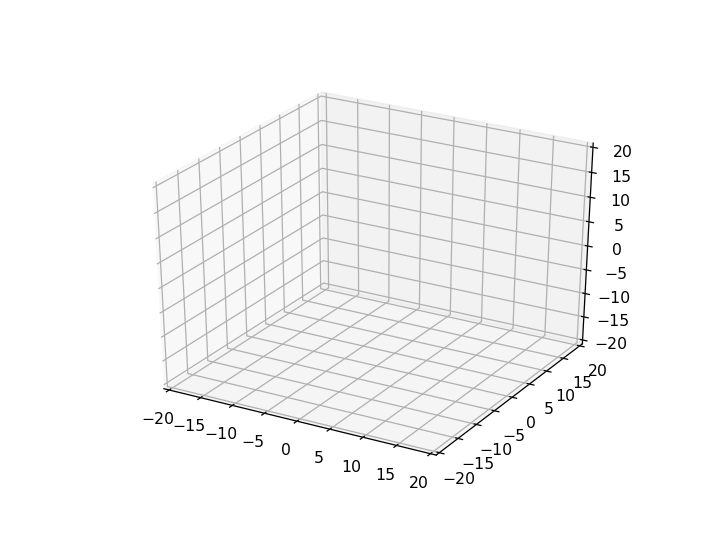

satellite0.png
satellite1.png
satellite2.png
satellite3.png
satellite4.png
satellite5.png
satellite6.png
satellite7.png
satellite8.png
satellite9.png
satellite10.png
satellite11.png
satellite12.png
satellite13.png
satellite14.png
satellite15.png
satellite16.png
satellite17.png
satellite18.png
satellite19.png
satellite20.png
satellite21.png
satellite22.png
satellite23.png
satellite24.png
satellite25.png
satellite26.png
satellite27.png
satellite28.png
satellite29.png
satellite30.png
satellite31.png
satellite32.png
satellite33.png
satellite34.png
satellite35.png
satellite36.png
satellite37.png
satellite38.png
satellite39.png
satellite40.png
satellite41.png
satellite42.png
satellite43.png
satellite44.png
satellite45.png
satellite46.png
satellite47.png
satellite48.png
satellite49.png
satellite50.png
satellite51.png
satellite52.png
satellite53.png
satellite54.png
satellite55.png
satellite56.png
satellite57.png
satellite58.png
satellite59.png
satellite60.png
satellite61.png
satellite62.png
sa

In [8]:
# Creates static images showing 3D rotation

#defining variables (satellite object dimensions)
h=height; #x-axis
l=length; #y-axis
w=width; #z-axis

#axis size
axis_size=max(w,max(h,l))+10;

#visualization

#creating satellie object

#corner points
p1=[-h,-l,-w];
p2=[h,-l,-w];
p3=[h,l,-w];
p4=[-h,l,-w];
p5=[-h,-l,w];
p6=[h,-l,w];
p7=[h,l,w];
p8=[-h,l,w];

vertices_bottom=np.array([[p1],[p2],[p3],[p4]]).reshape((4,3));
vertices_top=np.array([[p5],[p6],[p7],[p8]]).reshape((4,3));
vertices = np.array([[vertices_bottom], [vertices_top]]).reshape((8,3));
faces  = [[vertices[0],vertices[1],vertices[2],vertices[3]],
     [vertices[4],vertices[5],vertices[6],vertices[7]], 
     [vertices[0],vertices[1],vertices[5],vertices[4]], 
     [vertices[2],vertices[3],vertices[7],vertices[6]], 
     [vertices[1],vertices[2],vertices[6],vertices[5]],
     [vertices[4],vertices[7],vertices[3],vertices[0]]];

#set-up 3D plot
fig = plt.figure();
ax = fig.add_subplot(111, projection='3d');
ax.set_xlim3d((-axis_size,axis_size));
ax.set_ylim3d((-axis_size,axis_size));
ax.set_zlim3d((-axis_size,axis_size));

Storage=getSatellitePositionsRK4(timestep,tf,Moment_of_Inertia,Angular_Velocity);

N=Storage.shape[0];

for i in range(0,N):

    R=quatToRotMat3(Storage[i,4:8]);
    vertices = np.array([[vertices_bottom], [vertices_top]]).reshape(8,3);
    vertices = np.matmul(R, np.transpose(vertices));
    vertices = np.transpose(vertices);
    faces  = [[vertices[0],vertices[1],vertices[2],vertices[3]],
     [vertices[4],vertices[5],vertices[6],vertices[7]], 
     [vertices[0],vertices[1],vertices[5],vertices[4]], 
     [vertices[2],vertices[3],vertices[7],vertices[6]], 
     [vertices[1],vertices[2],vertices[6],vertices[5]],
     [vertices[4],vertices[7],vertices[3],vertices[0]]];
    
    # plot vertices
    ax.scatter3D(vertices[:, 0], vertices[:, 1], vertices[:, 2]);

    # plot sides
    ax.add_collection3d(Poly3DCollection(faces, facecolors='r', linewidths=1, edgecolors='k', alpha=.25));
    
    imagename ='satellite%d.png' % (i) # save each image to a different file name
    print(imagename)
    ax.set_xlim3d((-axis_size,axis_size));
    ax.set_ylim3d((-axis_size,axis_size));
    ax.set_zlim3d((-axis_size,axis_size));
    plt.savefig(imagename)
    plt.cla() # clear plot

print('DONE!')
ax.set_xlim3d((-axis_size,axis_size));
ax.set_ylim3d((-axis_size,axis_size));
ax.set_zlim3d((-axis_size,axis_size));